In [1]:
%matplotlib inline
import make_discrete_vdf as mdv
import numpy as np
import matplotlib.pyplot as plt
from fancy_plot import fancy_plot
from multiprocessing import Pool
import time
from scipy.optimize import curve_fit
import multi_fc_functions as mff

In [6]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [2]:
#set up plasma parameters
#                    Vx  ,  Vy,  Vz ,Wper,Wpar, Np
#pls_par = np.array([-380., -30., 30., 20., 40., 5.]) 
#pls_par = np.array([-580., 10., -10., 40., 120., 15.]) 
pls_par = np.array([-480., -100., -80., 20., 50., 25.])
#pls_par = np.array([-380., -100., 50., 30., 10., 50.]) 
#pls_par = np.array([-880., 100.,-150., 30., 10., 5.]) 
#mag_par = np.array([np.cos(np.radians(75.))*np.cos(.1), np.sin(np.radians(75.))*np.cos(.1), np.sin(.1)]) 
#mag_par = np.array([np.cos(np.radians(25.)),np.sin(np.radians(25.)), 0.]) 
mag_par = np.array([-1.,0., 0.])

#Set up observering condidtions before making any VDFs
#veloity grid
#########################################
######################################
#grid_v = np.arange(450,790,20)
v_mag = np.sqrt(np.sum(pls_par**2))
grid_v = np.arange(v_mag-150,v_mag+150,20)
#get effective area of wind and other coversion parameters
waeff = 3.8e6 #cm^3/km
q0    = 1.6021892e-7 # picocoulombs
dv    = np.diff(grid_v)
dv    = np.concatenate([dv,[dv[-1]]])
cont  = 1.e12/(waeff*q0*dv*grid_v)

In [3]:
#Changed to mean km/s in p,q space 2018/10/19
samp = 1.5e1
#make a discrete VDF
#updated clip to a velocity width 2018/10/12 J. Prchlik
#Set to a "Total velocity width" which could be measured by the space craft 2018/10/15
vel_clip = 4.*np.sqrt(np.sum(pls_par[4:6]**2))
dis_vdf = mdv.make_discrete_vdf(pls_par,mag_par,pres=1.00,qres=1.00,clip=vel_clip)



#get random angles of faraday cup in phi and theta
#number of fc cups
ncup = 20
#set random seed for FC angles
#np.random.seed(1107)


#Get two uniform number between -30 and 30
limit = 90.
phis = np.random.uniform(-limit,limit,size=ncup)
thetas = np.random.uniform(-30.,30.,size=ncup)


In [8]:

#array that store all the fit parameters 
big_arr = []
#calculate the "real measured reduced response function" for all fc cups
fcs = {}
for k,(phi,theta) in enumerate(zip(phis,thetas)):
    #calculate x_meas array
    x_meas = mdv.make_fc_meas(dis_vdf,fc_spd=grid_v,fc_phi=phi,fc_theta=theta)
    #compute the observed current in the instrument
    #Use dynamic sampling 2018/10/12 J. Prchlik
    #rea_cur = mdv.arb_p_response(x_meas,dis_vdf,samp)
    rad_phi,rad_theta = np.radians((phi,theta))
    pro_unt = np.array([np.cos(rad_phi)*np.cos(rad_theta),np.sin(rad_phi)*np.cos(rad_theta),np.sin(rad_theta)])
    peak = np.abs(pls_par[:3].dot(pro_unt))
    #here sampling is in km/s
    rea_cur = mdv.arb_p_response(x_meas,dis_vdf,samp)
    #switched back to static sampling but now using p',q',r' for sampling
    #rea_cur = mdv.arb_p_response_dyn_samp(x_meas,dis_vdf,peak)

    #create key for input fc
    key = 'fc_{0:1d}'.format(k)
    fcs[key] = {}

    #populate key with measurements and parameter 
    fcs[key]['x_meas']  = x_meas
    fcs[key]['rea_cur'] = rea_cur
    fcs[key]['peak']    = peak


    #calculate the Gaussian fit of the response
    try:
        popt, pcov = curve_fit(gaus,grid_v,rea_cur*cont,p0=[np.nanmax(rea_cur*cont),np.mean(grid_v),np.sqrt(2.)*2*dv[0]],sigma=1./(rea_cur/rea_cur.min()),maxfev=5000)
    except RuntimeError:
        #give number that will be thrown out if no fit is found 
        popt = np.zeros(3)-9999.9
        pcov = np.zeros((3,3))-9999.9


    #Switched to computing the average
    #####get the parameters from the fit
    u = popt[1] #speed in km/s
    w = np.abs(popt[2]*np.sqrt(2.)) #thermal speed in km/s
    n = popt[0]*w*np.sqrt(np.pi) #density in cc
    ####
    #####uncertainty in parameters from fit
    du = np.sqrt(pcov[1,1])
    dw = np.sqrt(pcov[2,2])
    dn = np.sqrt(np.pi*((w**2.*pcov[0,0]) + (dw*n)**2))


    #Add fit parameters with velocity guesses
    big_arr.append([u,w,n,phi,theta,du,dw,dn])


#convert big_arr intop numpy array
big_arr = np.array(big_arr)

/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in sqrt
/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in sqrt


In [9]:
#get speed solution per observatory
v_angl = big_arr[:,0]
uv_angl = big_arr[:,5]
#thermal speed in GSE
w_angl = big_arr[:,1]
uw_angl = big_arr[:,6]
#get the density to compute the magnitude
n_angl = big_arr[:,2]
un_angl = big_arr[:,7]



#Number of processors to use when parallel processing
nproc = 8




In [10]:
#Use the top 5 peaks to get density and velocity values if the number of measurements are greater than 5
top5 = n_angl > np.sort(n_angl)[-6]

#get v_gse solution (Produces the same solution as the Wind spacecraft solution)
#in /crater/observatories/wind/code/dvapbimax/sub_bimax_moments.pro
v_vec =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),-v_angl[top5]) #np.dot(np.dot(np.dot(v_svdc.T,wp_svdc),u_svdc.T),v_angl)
vx,vy,vz = v_vec


In [11]:
#Get Wper and Wpar vectors using SVD and the magnetic field vectors
wv_par =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),w_angl[top5])
wa = np.abs(wv_par.dot(mag_par))
we = np.sqrt(np.linalg.norm(wv_par)**2.-wv_par.dot(mag_par)**2.)



In [12]:
#compute angle between FC and the observed bulk velocity (cos(theta`))
n = np.median(np.abs(n_angl[top5]))

In [13]:
#dont let initial guess be smaller than half a bin size
if we < min(dv)/2.:
    we = min(dv)/2.


#make a discrete VDF with the incorrect parameters but the same grid
pls_par_bad = np.array([vx, vy, vz,we,wa,n])




In [14]:

######################################################################
######################################################################
#EVERYTHING BEFORE THIS WOULD BE MEASURED BY A SPACECRAFT
######################################################################
######################################################################

#Updated with vel_clip parameter 2108/10/12 J. Prchlik
dis_vdf_bad = mdv.make_discrete_vdf(pls_par_bad,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
#store the initial bad guess 
dis_vdf_bad_guess = dis_vdf_bad

In [15]:
#Get the initial distribution based on input parameters 2018/09/19 J. Prchlik 
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['init_guess'] = mdv.arb_p_response(fcs[i]['x_meas'],dis_vdf_bad_guess,samp)






In [16]:
#######Give info on best fit versus real solution######
print(pls_par)
print(pls_par_bad)

[-480. -100.  -80.   20.   50.   25.]
[-481.21570597  -97.25707429  -77.61096976   10.           50.23418102
   22.05619812]


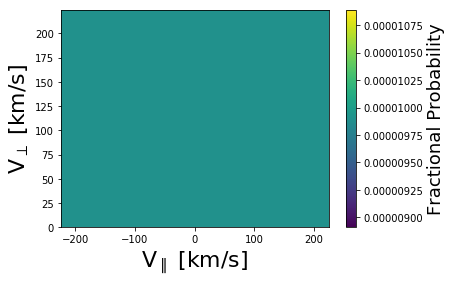

In [55]:
#create grid to call predictions
pred_grid = np.zeros(dis_vdf_bad_guess['pgrid'].shape)+1
pred_grid /= np.sum(pred_grid)
fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf['pgrid'],dis_vdf['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()


In [52]:
#Probability of selecting a gaussian that subtracts or adds to the vdf
n_p_prob = np.array([0.5,0.5])

#Inital bad sum squared error value
tot_err = 1e31 #a very large number
per_err = .10

#whether a given p, q value improved the fit
improved = False
ip,iq = 0.,0.

start_loop = time.time()
#takes about 1000 iterations to converge (~30 minutes), but converged to the wrong solution, mostly overestimated the peak
#removed to test improving fit
for i in range(10):
    #get a new vdf and return if it is the best fit
    #dis_vdf_bad,tot_error,dis_cur = create_random_vdf(dis_vdf_bad,nproc,n_p_prob)
    print('##############################################')
    #print('Before')
    #print(ip,iq,n_p_prob)
    fcs,tot_err,dis_vdf_bad,improved,ip,iq,n_p_prob = mff.create_random_vdf_multi_fc(fcs,nproc,tot_err,dis_vdf_bad,cont,
                                                                            improved=improved,ip=ip,iq=iq,n_p_prob=n_p_prob,
                                                                            sc_range=per_err,samp=samp)
    
    #print('After')
    #print(ip,iq,n_p_prob)   
    per_err = tot_err

    print('Total error for iteration {0:1d} is {1:4.3e}%'.format(i,100.*float(tot_err)))


##############################################
Total error for iteration 0 is 1.236e+01%
##############################################
Total error for iteration 1 is 1.236e+01%
##############################################
Total error for iteration 2 is 1.236e+01%
##############################################
Total error for iteration 3 is 1.236e+01%
##############################################
Total error for iteration 4 is 1.236e+01%
##############################################
Total error for iteration 5 is 1.236e+01%
##############################################
Total error for iteration 6 is 1.236e+01%
##############################################
Total error for iteration 7 is 1.236e+01%
##############################################
Total error for iteration 8 is 1.236e+01%
##############################################
Total error for iteration 9 is 1.236e+01%


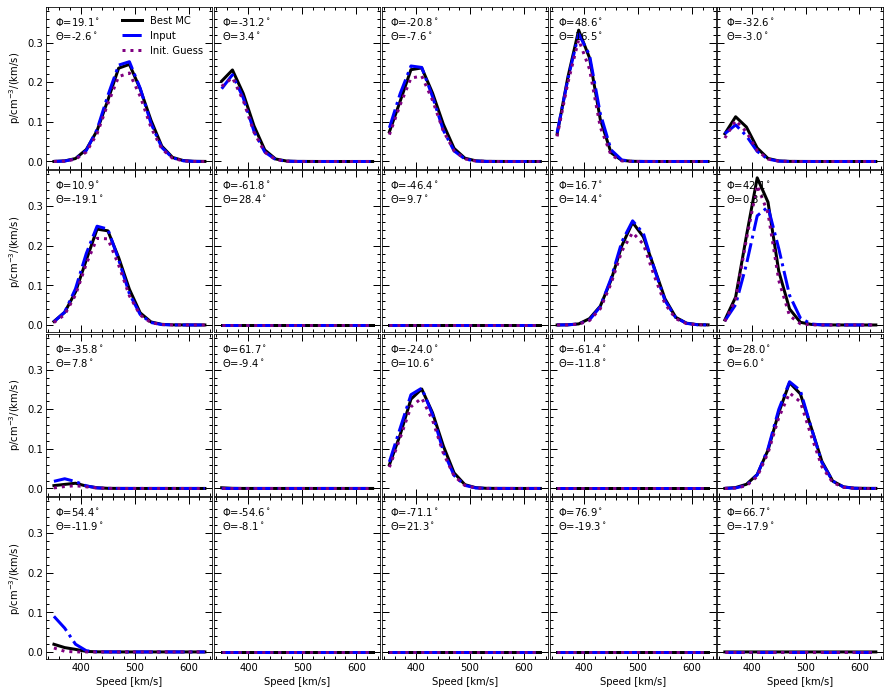

In [50]:
#Grid of FC guesses
mff.create_fc_grid_plot(fcs)
plt.show()

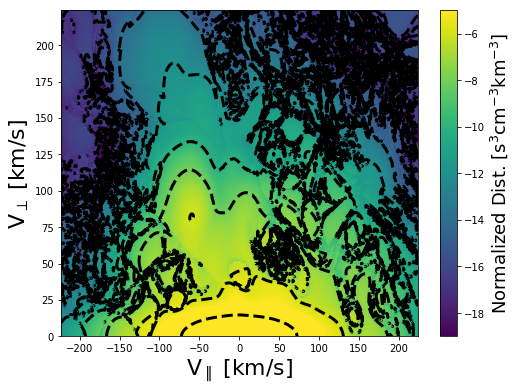

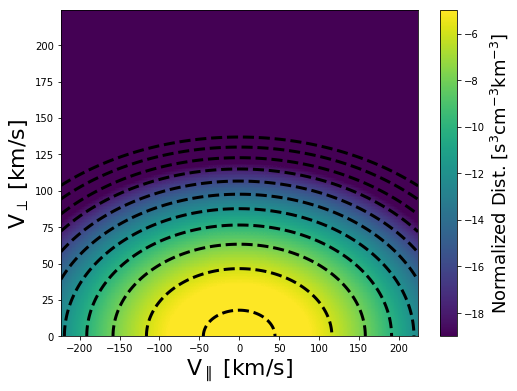

In [51]:
#Best Fit MC VDF
mdv.plot_vdf(dis_vdf_bad)

#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)

plt.show()

In [49]:
reload(mdv)
reload(mff)

<module 'multi_fc_functions' from 'multi_fc_functions.py'>